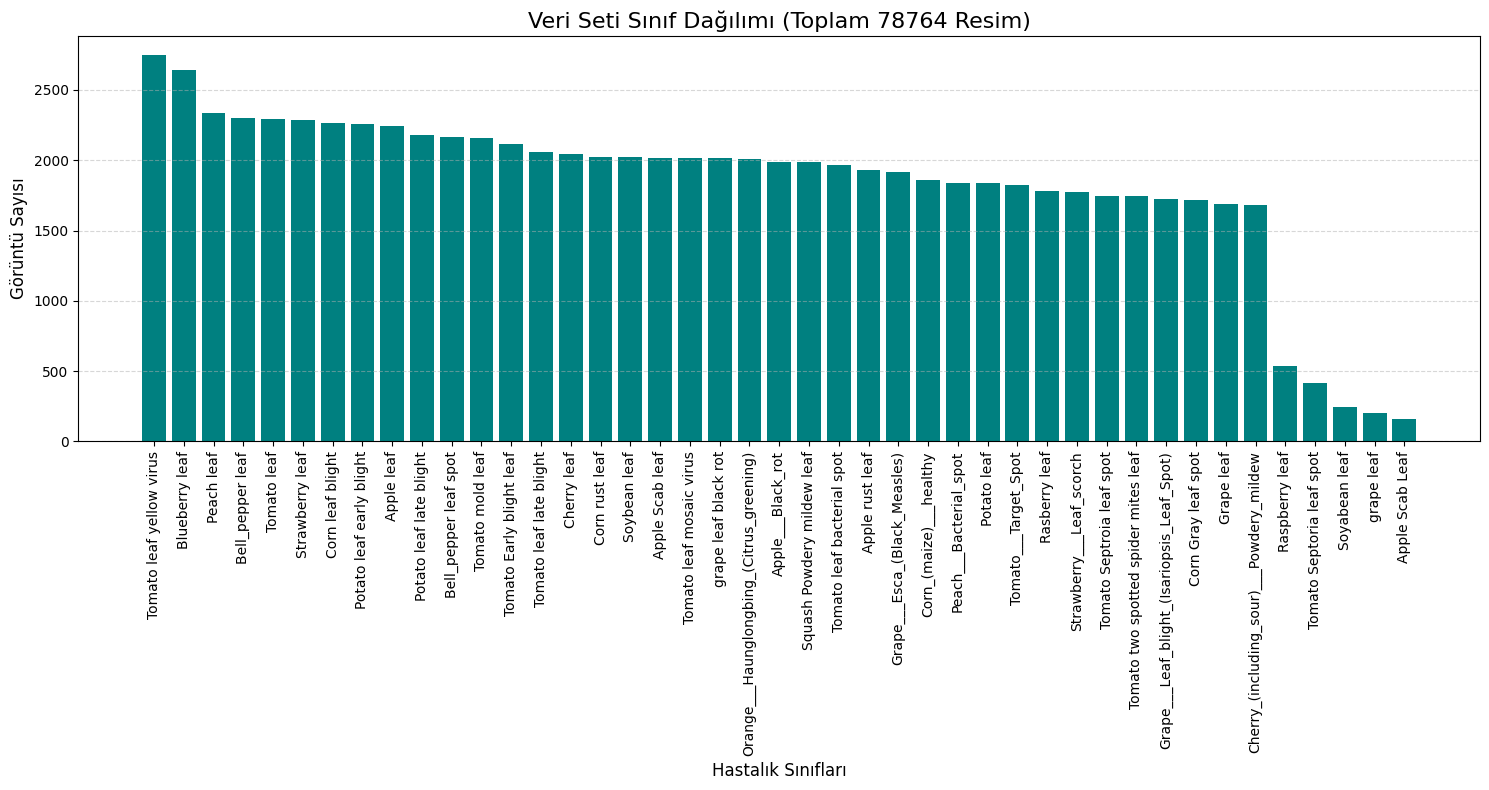

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

VERI_DOSYASI = r'C:\Users\User\BitkiProjesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'

df = pd.read_csv(VERI_DOSYASI)

sinif_sayilari = df['class'].value_counts()

plt.figure(figsize=(15, 8))
plt.bar(sinif_sayilari.index, sinif_sayilari.values, color='teal')


plt.xticks(rotation=90) 
plt.title(f"Veri Seti Sınıf Dağılımı (Toplam {len(df)} Resim)", fontsize=16)
plt.xlabel("Hastalık Sınıfları", fontsize=12)
plt.ylabel("Görüntü Sayısı", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import random
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

CSV_DOSYASI = r"C:\Users\User\BitkiProjesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv"
ANA_KLASOR = r"C:\Users\User\BitkiProjesi\New Plant Diseases Dataset(Augmented)\train"

BATCH_SIZE = 32 
LEARNING_RATE = 0.0001 
EPOCHS = 10
RESIM_BOYUTU = 224 

class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self):
        return len(self.veriler)

    def __getitem__(self, idx):
        dosya_adi = str(self.veriler.iloc[idx, 0])
        sinif_ismi = str(self.veriler.iloc[idx, 1])
        yol = os.path.join(self.root_dir, sinif_ismi, dosya_adi)
        
        try:
            image = Image.open(yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

def get_vgg16_model(num_classes):
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
    return model

if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    print("Veriler yükleniyor...")
    dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    num_classes = len(dataset.sinif_isimleri)
    model = get_vgg16_model(num_classes).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"\nRTX 4060 İLE EĞİTİM BAŞLIYOR... Raporlama her 150 adımda bir yapılacak.")
    print("-" * 65)

    for epoch in range(EPOCHS):
        model.train()
        train_loss, correct, total = 0, 0, 0
        start_time = time.time()
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i+1) % 150 == 0:
                print(f"Epoch [{epoch+1}/{EPOCHS}] | Adım [{i+1}/{len(train_loader)}] | Loss: {loss.item():.4f}")
        
        elapsed_time = time.time() - start_time
        print(f"\n>>> Epoch {epoch+1} Bitti | Süre: {elapsed_time:.1f} sn | Başarı: %{100 * correct / total:.2f}")
        
        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        print(f">>>> VAL ACC (Doğrulama): %{100 * val_correct / val_total:.2f}")
        print("-" * 65)

        torch.save(model.state_dict(), 'vgg16_bitki_modeli_final.pth')

    print("İşlem tamam! Model 'vgg16_bitki_modeli_final.pth' olarak kaydedildi.")

Kullanılan Cihaz: cuda
Veriler yükleniyor...

RTX 4060 İLE EĞİTİM BAŞLIYOR... Raporlama her 150 adımda bir yapılacak.
-----------------------------------------------------------------
Epoch [1/10] | Adım [150/1970] | Loss: 0.4676
Epoch [1/10] | Adım [300/1970] | Loss: 0.1004
Epoch [1/10] | Adım [450/1970] | Loss: 0.1479
Epoch [1/10] | Adım [600/1970] | Loss: 0.1252
Epoch [1/10] | Adım [750/1970] | Loss: 0.0832
Epoch [1/10] | Adım [900/1970] | Loss: 0.1224
Epoch [1/10] | Adım [1050/1970] | Loss: 0.1969
Epoch [1/10] | Adım [1200/1970] | Loss: 0.4232
Epoch [1/10] | Adım [1350/1970] | Loss: 0.0417
Epoch [1/10] | Adım [1500/1970] | Loss: 0.1783
Epoch [1/10] | Adım [1650/1970] | Loss: 0.0346
Epoch [1/10] | Adım [1800/1970] | Loss: 0.1888
Epoch [1/10] | Adım [1950/1970] | Loss: 0.0362

>>> Epoch 1 Bitti | Süre: 894.1 sn | Başarı: %92.33
>>>> VAL ACC (Doğrulama): %97.64
-----------------------------------------------------------------
Epoch [2/10] | Adım [150/1970] | Loss: 0.1945
Epoch [2/10] 

In [7]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import random
from sklearn.metrics import f1_score, accuracy_score, classification_report

# --- 1. YOLLAR VE AYARLAR ---
CSV_DOSYASI = r"C:\Users\User\BitkiProjesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv"
ANA_KLASOR = r"C:\Users\User\BitkiProjesi\New Plant Diseases Dataset(Augmented)\train"
MODEL_PATH = "vgg16_bitki_modeli_final.pth" 

BATCH_SIZE = 32 # RTX 4060 için ideal
RESIM_BOYUTU = 224 # VGG16 standart boyutu

# Donanım Kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Test işlemi için kullanılan cihaz: {device}")
if torch.cuda.is_available():
    print(f"Ekran Kartı: {torch.cuda.get_device_name(0)}")

# --- 2. VERİ SETİ SINIFI ---
class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            
            yol = os.path.join(self.root_dir, sinif_ismi, dosya_adi)
            
            image = Image.open(yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

# --- 3. ANA ÇALIŞMA BLOĞU ---
if __name__ == '__main__':
    print("Test Verileri Hazırlanıyor...")
    
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    
    # Eğitimdeki ayrım oranının aynısı (%20 validation/test seti)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    _, val_dataset = random_split(dataset, [train_size, val_size])
    
    test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Test Edilecek Görüntü Sayısı: {len(val_dataset)}")
    
    # --- MODELİ YÜKLEME ---
    num_classes = len(dataset.sinif_isimleri)
    print(f"VGG16 mimarisi oluşturuluyor...")
    
    model = models.vgg16(weights=None)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
    
    model = model.to(device)
    
    if os.path.exists(MODEL_PATH):
        print(f"Eğitilmiş model yükleniyor: {MODEL_PATH}")
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        model.eval() 
    else:
        print(f"HATA: '{MODEL_PATH}' bulunamadı! Dosya adını kontrol et.")
        exit()

    print("\nTEST BAŞLIYOR... (Lütfen bekleyin)")
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            if (i+1) % 50 == 0:
                print(f"   İşlenen paket: {i+1}/{len(test_loader)}...")

    # --- PERFORMANS RAPORLAMASI ---
    acc = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    
    print("\n" + "="*60)
    print("VGG16 MODEL PERFORMANS ANALİZİ")
    print("="*60)
    print(f"Genel Doğruluk (Accuracy): %{acc*100:.2f}")
    print(f"Genel F1 Skoru (Weighted): {f1_weighted:.4f}")
    print("-" * 60)
    
    print("\nDETAYLI HASTALIK RAPORU:")
    
    # Hatanın çözümü: Tüm 43 sınıfı içeren indeks listesi
    class_indices = list(range(len(dataset.sinif_isimleri)))
    
    print(classification_report(
        all_labels, 
        all_preds, 
        labels=class_indices, # 36 sınıf olsa bile 43'e tamamlar
        target_names=dataset.sinif_isimleri,
        zero_division=0 # Verisi olmayan sınıflar için 0 yazar, hata vermez
    ))

Test işlemi için kullanılan cihaz: cuda
Ekran Kartı: NVIDIA GeForce RTX 4060
Test Verileri Hazırlanıyor...
Test Edilecek Görüntü Sayısı: 15753
VGG16 mimarisi oluşturuluyor...
Eğitilmiş model yükleniyor: vgg16_bitki_modeli_final.pth

TEST BAŞLIYOR... (Lütfen bekleyin)


C:\Users\User\AppData\Local\Temp\ipykernel_16236\515384512.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=dev

   İşlenen paket: 50/493...
   İşlenen paket: 100/493...
   İşlenen paket: 150/493...
   İşlenen paket: 200/493...
   İşlenen paket: 250/493...
   İşlenen paket: 300/493...
   İşlenen paket: 350/493...
   İşlenen paket: 400/493...
   İşlenen paket: 450/493...

VGG16 MODEL PERFORMANS ANALİZİ
Genel Doğruluk (Accuracy): %99.30
Genel F1 Skoru (Weighted): 0.9930
------------------------------------------------------------

DETAYLI HASTALIK RAPORU:
                                            precision    recall  f1-score   support

                           Apple Scab Leaf       0.00      0.00      0.00         0
                           Apple Scab leaf       0.99      1.00      0.99       487
                                Apple leaf       1.00      1.00      1.00       468
                           Apple rust leaf       1.00      1.00      1.00       409
                         Apple___Black_rot       1.00      1.00      1.00       462
                          Bell_pepper leaf      

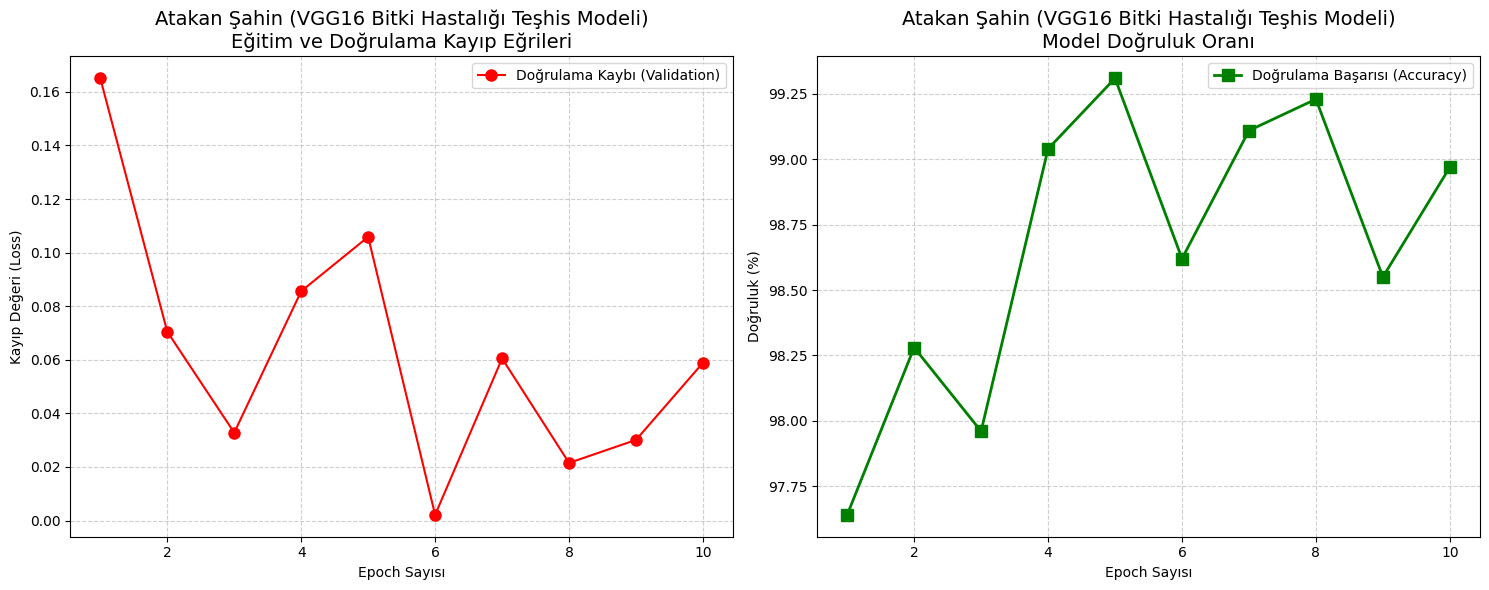

In [9]:
import matplotlib.pyplot as plt

USER_INFO = "Atakan Şahin (VGG16 Bitki Hastalığı Teşhis Modeli)"

epochs = list(range(1, 11))

val_losses = [0.1651, 0.0705, 0.0328, 0.0856, 0.1059, 0.0021, 0.0605, 0.0215, 0.0301, 0.0589]
accuracies = [97.64, 98.28, 97.96, 99.04, 99.31, 98.62, 99.11, 99.23, 98.55, 98.97]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'r-o', markersize=8, label='Doğrulama Kaybı (Validation)')
plt.title(f'{USER_INFO}\nEğitim ve Doğrulama Kayıp Eğrileri', fontsize=14)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Kayıp Değeri (Loss)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g-s', linewidth=2, markersize=8, label='Doğrulama Başarısı (Accuracy)')
plt.title(f'{USER_INFO}\nModel Doğruluk Oranı', fontsize=14)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk (%)')

# Y eksenini verilerinin başlangıcına göre otomatik ayarlar
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()

plt.show()

In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import random
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

CSV_DOSYASI = r"C:\Users\User\BitkiProjesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv"
ANA_KLASOR = r"C:\Users\User\BitkiProjesi\New Plant Diseases Dataset(Augmented)\train"

BATCH_SIZE = 32 
LEARNING_RATE = 0.0001 
EPOCHS = 10
RESIM_BOYUTU = 224 

class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self):
        return len(self.veriler)

    def __getitem__(self, idx):
        dosya_adi = str(self.veriler.iloc[idx, 0])
        sinif_ismi = str(self.veriler.iloc[idx, 1])
        yol = os.path.join(self.root_dir, sinif_ismi, dosya_adi)
        
        try:
            image = Image.open(yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

def get_densenet121_model(num_classes):
    # Hazır eğitilmiş DenseNet121 ağırlıklarını yüklüyoruz
    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    
    # DenseNet'te çıkış katmanı 'classifier' adındadır
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
    return model

if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    print("Veriler yükleniyor...")
    dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    num_classes = len(dataset.sinif_isimleri)
    model = get_densenet121_model(num_classes).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"\nRTX 4060 İLE DENSENET121 EĞİTİMİ BAŞLIYOR... Raporlama her 150 adımda bir.")
    print("-" * 65)

    for epoch in range(EPOCHS):
        model.train()
        train_loss, correct, total = 0, 0, 0
        start_time = time.time()
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i+1) % 150 == 0:
                print(f"Epoch [{epoch+1}/{EPOCHS}] | Adım [{i+1}/{len(train_loader)}] | Loss: {loss.item():.4f}")
        
        elapsed_time = time.time() - start_time
        print(f"\n>>> Epoch {epoch+1} Bitti | Süre: {elapsed_time:.1f} sn | Başarı: %{100 * correct / total:.2f}")
        
        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        print(f">>>> VAL ACC (Doğrulama): %{100 * val_correct / val_total:.2f}")
        print("-" * 65)

        # Modeli kaydet
        torch.save(model.state_dict(), 'densenet121_bitki_modeli.pth')

    print("İşlem tamam! Model 'densenet121_bitki_modeli.pth' olarak kaydedildi.")

Kullanılan Cihaz: cuda
Veriler yükleniyor...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\User/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100.0%



RTX 4060 İLE DENSENET121 EĞİTİMİ BAŞLIYOR... Raporlama her 150 adımda bir.
-----------------------------------------------------------------
Epoch [1/10] | Adım [150/1970] | Loss: 0.4732
Epoch [1/10] | Adım [300/1970] | Loss: 0.2334
Epoch [1/10] | Adım [450/1970] | Loss: 0.2686
Epoch [1/10] | Adım [600/1970] | Loss: 0.2230
Epoch [1/10] | Adım [750/1970] | Loss: 0.1059
Epoch [1/10] | Adım [900/1970] | Loss: 0.0945
Epoch [1/10] | Adım [1050/1970] | Loss: 0.0179
Epoch [1/10] | Adım [1200/1970] | Loss: 0.1315
Epoch [1/10] | Adım [1350/1970] | Loss: 0.0678
Epoch [1/10] | Adım [1500/1970] | Loss: 0.0182
Epoch [1/10] | Adım [1650/1970] | Loss: 0.0116
Epoch [1/10] | Adım [1800/1970] | Loss: 0.0402
Epoch [1/10] | Adım [1950/1970] | Loss: 0.0163

>>> Epoch 1 Bitti | Süre: 474.2 sn | Başarı: %96.75
>>>> VAL ACC (Doğrulama): %99.27
-----------------------------------------------------------------
Epoch [2/10] | Adım [150/1970] | Loss: 0.0714
Epoch [2/10] | Adım [300/1970] | Loss: 0.0140
Epoch [2/

In [10]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import random
from sklearn.metrics import f1_score, accuracy_score, classification_report

CSV_DOSYASI = r"C:\Users\User\BitkiProjesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv"
ANA_KLASOR = r"C:\Users\User\BitkiProjesi\New Plant Diseases Dataset(Augmented)\train"
MODEL_PATH = "densenet121_bitki_modeli.pth" 

BATCH_SIZE = 32 
RESIM_BOYUTU = 224 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Test işlemi için kullanılan cihaz: {device}")
if torch.cuda.is_available():
    print(f"Ekran Kartı: {torch.cuda.get_device_name(0)}")

class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            
            yol = os.path.join(self.root_dir, sinif_ismi, dosya_adi)
            
            image = Image.open(yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

if __name__ == '__main__':
    print("Test Verileri Hazırlanıyor...")
    
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    _, val_dataset = random_split(dataset, [train_size, val_size])
    
    test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Test Edilecek Görüntü Sayısı: {len(val_dataset)}")
    

    num_classes = len(dataset.sinif_isimleri)
    print(f"DenseNet121 mimarisi oluşturuluyor...")
    
    model = models.densenet121(weights=None)
    
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
    
    model = model.to(device)
    
    if os.path.exists(MODEL_PATH):
        print(f"Eğitilmiş model yükleniyor: {MODEL_PATH}")
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        model.eval() 
    else:
        print(f"HATA: '{MODEL_PATH}' bulunamadı! Dosya adını kontrol et.")
        exit()

    print("\nTEST BAŞLIYOR... (Lütfen bekleyin)")
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            if (i+1) % 50 == 0:
                print(f"   İşlenen paket: {i+1}/{len(test_loader)}...")

    acc = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    
    print("\n" + "="*60)
    print("DENSENET121 MODEL PERFORMANS ANALİZİ")
    print("="*60)
    print(f"Genel Doğruluk (Accuracy): %{acc*100:.2f}")
    print(f"Genel F1 Skoru (Weighted): {f1_weighted:.4f}")
    print("-" * 60)
    
    print("\nDETAYLI HASTALIK RAPORU:")
    
    class_indices = list(range(len(dataset.sinif_isimleri)))
    
    print(classification_report(
        all_labels, 
        all_preds, 
        labels=class_indices, 
        target_names=dataset.sinif_isimleri,
        zero_division=0 
    ))

Test işlemi için kullanılan cihaz: cuda
Ekran Kartı: NVIDIA GeForce RTX 4060
Test Verileri Hazırlanıyor...
Test Edilecek Görüntü Sayısı: 15753
DenseNet121 mimarisi oluşturuluyor...
Eğitilmiş model yükleniyor: densenet121_bitki_modeli.pth


C:\Users\User\AppData\Local\Temp\ipykernel_16236\3675155189.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=de


TEST BAŞLIYOR... (Lütfen bekleyin)
   İşlenen paket: 50/493...
   İşlenen paket: 100/493...
   İşlenen paket: 150/493...
   İşlenen paket: 200/493...
   İşlenen paket: 250/493...
   İşlenen paket: 300/493...
   İşlenen paket: 350/493...
   İşlenen paket: 400/493...
   İşlenen paket: 450/493...

DENSENET121 MODEL PERFORMANS ANALİZİ
Genel Doğruluk (Accuracy): %99.97
Genel F1 Skoru (Weighted): 0.9997
------------------------------------------------------------

DETAYLI HASTALIK RAPORU:
                                            precision    recall  f1-score   support

                           Apple Scab Leaf       0.00      0.00      0.00         0
                           Apple Scab leaf       1.00      1.00      1.00       450
                                Apple leaf       1.00      1.00      1.00       450
                           Apple rust leaf       1.00      1.00      1.00       405
                         Apple___Black_rot       1.00      1.00      1.00       470
      

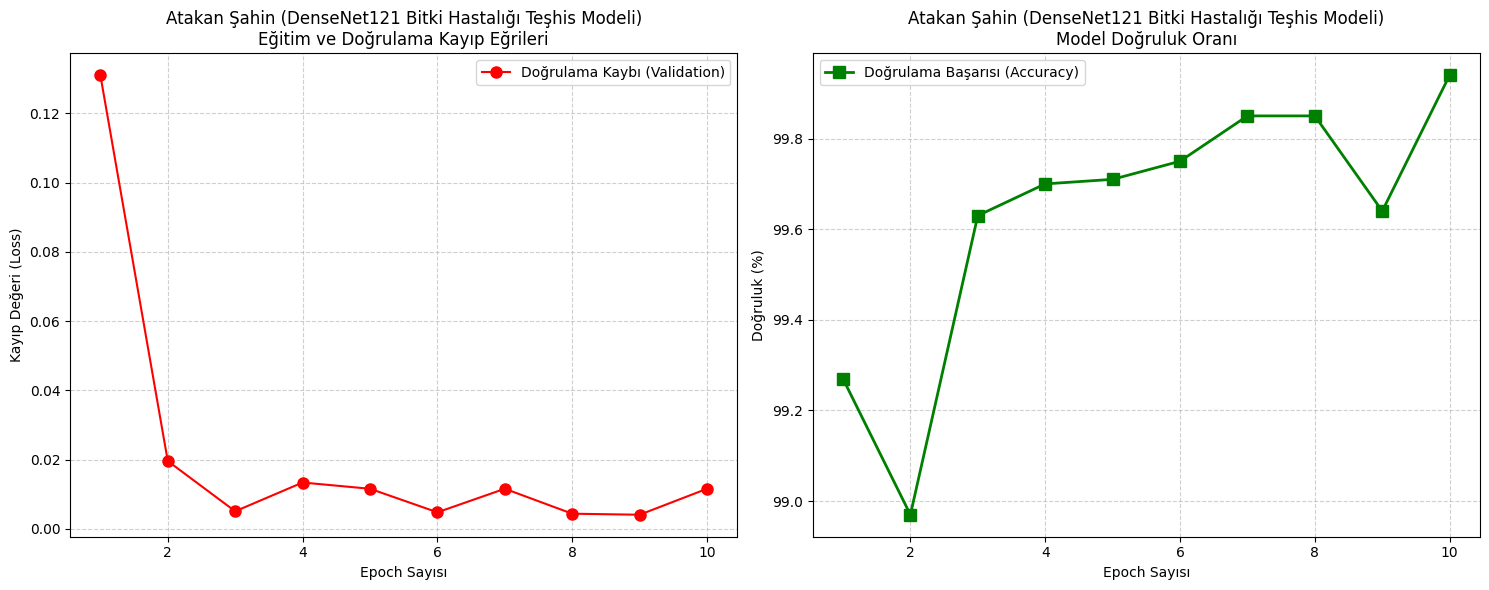

In [13]:
import matplotlib.pyplot as plt

USER_INFO = "Atakan Şahin (DenseNet121 Bitki Hastalığı Teşhis Modeli)"

epochs = list(range(1, 11))

val_losses = [0.1310, 0.0196, 0.0051, 0.0134, 0.0116, 0.0048, 0.0116, 0.0044, 0.0041, 0.0116]
accuracies = [99.27, 98.97, 99.63, 99.70, 99.71, 99.75, 99.85, 99.85, 99.64, 99.94]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'r-o', markersize=8, label='Doğrulama Kaybı (Validation)')
plt.title(f'{USER_INFO}\nEğitim ve Doğrulama Kayıp Eğrileri', fontsize=12)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Kayıp Değeri (Loss)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g-s', linewidth=2, markersize=8, label='Doğrulama Başarısı (Accuracy)')
plt.title(f'{USER_INFO}\nModel Doğruluk Oranı', fontsize=12)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk (%)')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

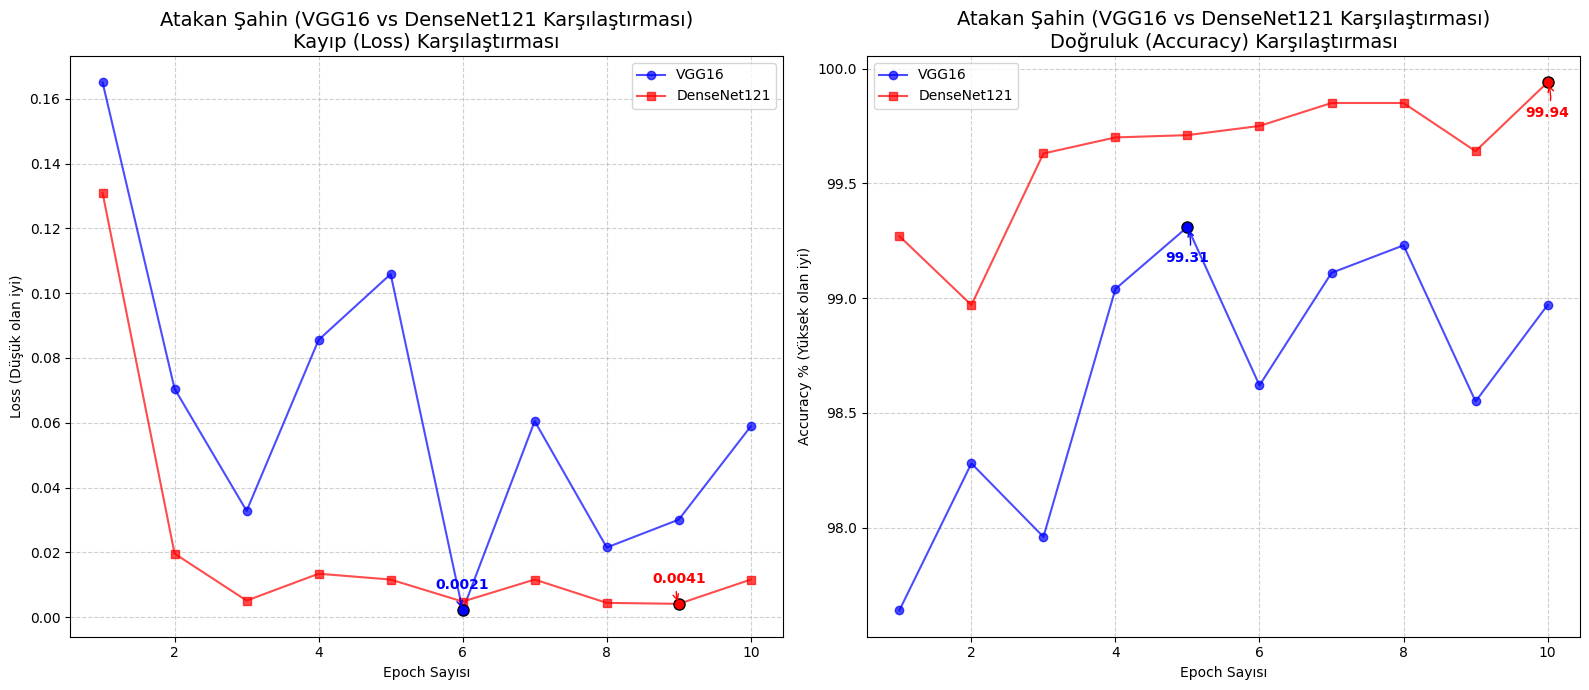

In [16]:
import matplotlib.pyplot as plt
import numpy as np

USER_INFO = "Atakan Şahin (VGG16 vs DenseNet121 Karşılaştırması)"

epochs = list(range(1, 11))

vgg_loss = [0.1651, 0.0705, 0.0328, 0.0856, 0.1059, 0.0021, 0.0605, 0.0215, 0.0301, 0.0589]
vgg_acc  = [97.64, 98.28, 97.96, 99.04, 99.31, 98.62, 99.11, 99.23, 98.55, 98.97]

dense_loss = [0.1310, 0.0196, 0.0051, 0.0134, 0.0116, 0.0048, 0.0116, 0.0044, 0.0041, 0.0116]
dense_acc  = [99.27, 98.97, 99.63, 99.70, 99.71, 99.75, 99.85, 99.85, 99.64, 99.94]

def isaretle(x, y, tip='min', renk='black'):
    """Grafik üzerine en iyi değeri ok ile işaretler"""
    if tip == 'min':
        target_val = min(y)
        idx = y.index(target_val)
        xy_text_offset = (0, 15)
    else: # max
        target_val = max(y)
        idx = y.index(target_val)
        xy_text_offset = (0, -25)

    target_epoch = x[idx]
    
    plt.annotate(f'{target_val}', 
                 xy=(target_epoch, target_val), 
                 xytext=xy_text_offset,
                 textcoords='offset points',
                 ha='center',
                 color=renk,
                 fontweight='bold',
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color=renk))
    
    plt.plot(target_epoch, target_val, marker='o', markersize=8, markeredgecolor='black', markerfacecolor=renk)

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, vgg_loss, 'b-o', label='VGG16', alpha=0.7)
plt.plot(epochs, dense_loss, 'r-s', label='DenseNet121', alpha=0.7)

isaretle(epochs, vgg_loss, tip='min', renk='blue')
isaretle(epochs, dense_loss, tip='min', renk='red')

plt.title(f'{USER_INFO}\nKayıp (Loss) Karşılaştırması', fontsize=14)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Loss (Düşük olan iyi)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, vgg_acc, 'b-o', label='VGG16', alpha=0.7)
plt.plot(epochs, dense_acc, 'r-s', label='DenseNet121', alpha=0.7)

isaretle(epochs, vgg_acc, tip='max', renk='blue')
isaretle(epochs, dense_acc, tip='max', renk='red')

plt.title(f'{USER_INFO}\nDoğruluk (Accuracy) Karşılaştırması', fontsize=14)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Accuracy % (Yüksek olan iyi)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
from IPython.display import display

vgg16_acc_list = [97.64, 98.28, 97.96, 99.04, 99.31, 98.62, 99.11, 99.23, 98.55, 98.97]
vgg16_loss_list = [0.1651, 0.0705, 0.0328, 0.0856, 0.1059, 0.0021, 0.0605, 0.0215, 0.0301, 0.0589]

densenet_acc_list = [99.27, 98.97, 99.63, 99.70, 99.71, 99.75, 99.85, 99.85, 99.64, 99.94]
densenet_loss_list = [0.1310, 0.0196, 0.0051, 0.0134, 0.0116, 0.0048, 0.0116, 0.0044, 0.0041, 0.0116]

vgg_best_acc = max(vgg16_acc_list)
vgg_min_loss = min(vgg16_loss_list)

dense_best_acc = max(densenet_acc_list)
dense_min_loss = min(densenet_loss_list)

results = {
    "Model Mimarisi": ["VGG16", "DenseNet121"],
    "En Yüksek Doğrulama Başarısı (%)": [f"%{vgg_best_acc:.2f}", f"%{dense_best_acc:.2f}"],
    "En Düşük Kayıp (Loss)": [f"{vgg_min_loss:.4f}", f"{dense_min_loss:.4f}"],
    "Geliştirici": ["Atakan Şahin", "Atakan Şahin"]
}

df_results = pd.DataFrame(results)

print("\n" + "="*60)
print("  BİTKİ HASTALIKLARI TEŞHİSİ - MODEL KARŞILAŞTIRMA (FİNAL)  ")
print("="*60)

display(df_results)


  BİTKİ HASTALIKLARI TEŞHİSİ - MODEL KARŞILAŞTIRMA (FİNAL)  


,Model Mimarisi,En Yüksek Doğrulama Başarısı (%),En Düşük Kayıp (Loss),Geliştirici
0,VGG16,%99.31,0.0021,Atakan Şahin
1,DenseNet121,%99.94,0.0041,Atakan Şahin
